## Background

Pemeriksaan barang bawaan menggunakan pemindai sinar-X sudah menjadi bagian penting di banyak tempat, seperti bandara, gedung pemerintahan, atau pusat acara besar. Tujuannya adalah untuk memastikan tidak ada benda berbahaya atau terlarang yang masuk ke dalam area tersebut.

Namun, membaca gambar hasil pemindaian sinar-X menjadi suatu tantangan karena berbagai macam barang dengan bentuk dan material yang berbeda bisa tampak mirip. Oleh karena itu, teknologi kecerdasan buatan mulai digunakan untuk membantu mengenali benda-benda yang mencurigakan secara otomatis.

Sistem deteksi anomali berbasis computer vision ini dapat memproses gambar sinar-X dan mengidentifikasi barang-barang yang tidak biasa atau berpotensi berbahaya, sehingga mempercepat proses pemeriksaan dan meningkatkan keamanan di berbagai tempat.

## Dataset Description

Source: https://www.kaggle.com/datasets/orvile/x-ray-baggage-anomaly-detection/data

Dataset ini berisi gambar hasil pemindaian sinar-X dari tas dan koper dengan berbagai barang di dalamnya. Ada gambar yang menunjukkan isi tas biasa, dan ada juga yang berisi benda mencurigakan seperti senjata atau barang berbahaya.

Setiap gambar sudah diberi tanda atau label supaya kita tahu mana yang normal dan mana yang aneh. Data ini dibagi supaya bisa dipakai untuk melatih komputer mengenali benda berbahaya, lalu diuji agar hasilnya akurat saat dipakai di dunia nyata.

## Import Librarie

In [2]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import yaml
import itertools
from collections import Counter

import tensorflow as tf

## Load data

In [3]:
TRAIN_DATASET_PATH = "./dataset/train/"
VAL_DATASET_PATH = "./dataset/valid/"
TEST_DATASET_PATH = "./dataset/test/"

In [4]:
path = TRAIN_DATASET_PATH + "labels"

dct = {
    "images": [],
    "labels": [],
    "x_center": [],
    "y_center": [],
    "width": [],
    "height": []
}

for image in os.listdir(path):
    label_file = open(path + "/" + image)

    labels_str = label_file.read().split(sep="\n")
    labels_arr = []
    xmin_arr = []
    ymin_arr = []
    xmax_arr = []
    ymax_arr = []
    for label in labels_str:
        label_parts = label.split()
        labels_arr.append(int(label_parts[0]))
        xmin_arr.append(float(label_parts[1]))
        ymin_arr.append(float(label_parts[2]))
        xmax_arr.append(float(label_parts[3]))
        ymax_arr.append(float(label_parts[4]))

    dct["images"].append(image)
    dct["labels"].append(labels_arr)
    dct["x_center"].append(xmin_arr)
    dct["y_center"].append(ymin_arr)
    dct["width"].append(xmax_arr)
    dct["height"].append(ymax_arr)

    label_file.close()

df = pd.DataFrame(dct)
df

images labels  \
0     009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...    [2]   
1     009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...    [2]   
2     009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...    [2]   
3     009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...    [2]   
4     009012_jpg.rf.bc99877ade8754d2be89119361e7820c...    [2]   
...                                                 ...    ...   
6176  042973_jpg.rf.6792837ba2183435721cd7b4e9674ecd...    [1]   
6177  042982_jpg.rf.79a8b11af76f74faa44312da78ee1486...    [4]   
6178  042984_jpg.rf.5005cade401420afa36aac4b818e8dfa...    [1]   
6179  042994_jpg.rf.141176d36edf4a11d33dad95a76e61b6...    [1]   
6180  042996_jpg.rf.09fa6ea27e4110355c4cc9c938e71419...    [4]   

                  x_center               y_center                   width  \
0     [0.6538461538461539]   [0.5420673076923077]                [0.0625]   
1     [0.5576923076923077]   [0.3389423076923077]  [0.055288461538461536]   
2     [0.4230769230769231]   [0.3798076923076923]   [0.09975961538461539]   
3     [0.4014423076923077]  [0.35096153846153844]  [0.055288461538461536]   
4     [0.8040865384615384]   [0.3870192307692308]  [0.052884615384615384]   
...                    ...                    ...                     ...   
6176  [0.3485576923076923]   [0.3016826923076923]   [0.08533653846153846]   
6177  [0.3629807692307692]   [0.5276442307692307]                [0.0625]   
6178  [0.3870192307692308]  [0.36778846153846156]   [0.04447115384615385]   
6179  [0.5084134615384616]   [0.5492788461538461]    [0.0889423076923077]   
6180  [0.7764423076923077]   [0.6189903846153846]  [0.051682692307692304]   

                      height  
0      [0.06610576923076923]  
1      [0.07091346153846154]  
2     [0.055288461538461536]  
3       [0.1778846153846154]  
4      [0.07211538461538461]  
...                      ...  
6176   [0.08653846153846154]  
6177   [0.16706730769230768]  
6178  [0.052884615384615384]  
6179   [0.06370192307692307]  
6180   [0.11538461538461539]  

[6181 rows x 6 columns]

In [15]:
# class 0
df[df["labels"].isin([[0]])][:30]

images labels  \
691  016001_jpg.rf.775b7cefabec3bc0c8afdd13c7d2dc44...    [0]   
692  016020_jpg.rf.d1cf072a80f90710519f7da6054f5645...    [0]   
693  016023_jpg.rf.df81710c5939613def4083afc3ecd2df...    [0]   
694  016027_jpg.rf.513665acb1f2f2023e77fbf3bf8ee050...    [0]   
695  016036_jpg.rf.de8995a796438d060463acd14e784677...    [0]   
696  016049_jpg.rf.80427f147f31ccefbbaaa3fa61f0124a...    [0]   
697  016058_jpg.rf.80dc72563c6532e6684d7cdebe07d565...    [0]   
698  016060_jpg.rf.e95917bda695e7de04067c2cb060664d...    [0]   
699  016070_jpg.rf.65fbe70dd87778b88e20144c7e61fa9d...    [0]   
700  016072_jpg.rf.6634ac1a0e80e0ae060bd10054a02013...    [0]   
701  016076_jpg.rf.f9f3ae4ff3be2ab2a10fbed5960b5a5f...    [0]   
702  016080_jpg.rf.1b9098a8ba2864c35f120385d37fb144...    [0]   
703  016084_jpg.rf.4d16959f29303cd8fedb6ebc143c9122...    [0]   
704  016086_jpg.rf.349bfe343ad316bbd892d15fbdcde660...    [0]   
705  016092_jpg.rf.8fec747c10aa352abf3d13e54ee85ebf...    [0]   
706  016100_jpg.rf.fbdb8d20465dc0166c0a577e9720548f...    [0]   
707  016115_jpg.rf.fad9bf287ff3dfdd69c735fa58e090a5...    [0]   
708  016124_jpg.rf.c55ba3f3b7d9a15288eeb49d582754a1...    [0]   
709  016127_jpg.rf.8f69489867462afa329405ea66a77b3e...    [0]   
710  016139_jpg.rf.db637b37a8bad62263099e81b09dd604...    [0]   
711  016140_jpg.rf.b1167ed283e9da3250d6372a416c87dd...    [0]   
712  016145_jpg.rf.f14aad8f80c4c6a31704cf375ef2f025...    [0]   
713  016151_jpg.rf.89eee0350fe209241253e446ea323a48...    [0]   
714  016172_jpg.rf.a8a47f92f76f13d7f27843f47d9cd407...    [0]   
715  016180_jpg.rf.e751ece2254482b4cecf8d8f0501eb87...    [0]   
716  016182_jpg.rf.b94982567a79eb817f58e39ccc7dea93...    [0]   
717  016183_jpg.rf.c3391914114b999e6e9831f6692ced8e...    [0]   
718  016194_jpg.rf.f67fa3cb3779f050b3e432b11b1d7e39...    [0]   
719  016207_jpg.rf.1247868d43e045084ec1075d9b01f2ab...    [0]   
720  016218_jpg.rf.ec1ed15104000e55f7a745a53d02e163...    [0]   

                  x_center               y_center                   width  \
691   [0.6694711538461539]   [0.5504807692307693]   [0.15144230769230768]   
692   [0.5360576923076923]   [0.6069711538461539]    [0.1466346153846154]   
693   [0.5528846153846154]   [0.6069711538461539]   [0.04927884615384615]   
694   [0.4543269230769231]   [0.6298076923076923]   [0.10096153846153846]   
695   [0.6057692307692307]   [0.5649038461538461]              [0.078125]   
696   [0.4206730769230769]  [0.45552884615384615]  [0.055288461538461536]   
697   [0.5877403846153846]  [0.47836538461538464]   [0.11057692307692307]   
698   [0.7307692307692307]   [0.4807692307692308]   [0.10096153846153846]   
699   [0.6814903846153846]   [0.4567307692307692]              [0.078125]   
700   [0.7451923076923077]   [0.4074519230769231]   [0.14302884615384615]   
701   [0.5865384615384616]   [0.5973557692307693]              [0.109375]   
702   [0.4951923076923077]  [0.41466346153846156]   [0.07692307692307693]   
703   [0.5456730769230769]  [0.45913461538461536]   [0.24519230769230768]   
704   [0.6923076923076923]   [0.5084134615384616]    [0.2548076923076923]   
705   [0.3137019230769231]  [0.38461538461538464]   [0.08653846153846154]   
706   [0.5432692307692307]   [0.5793269230769231]   [0.22716346153846154]   
707   [0.2848557692307692]   [0.5144230769230769]   [0.07211538461538461]   
708   [0.6201923076923077]   [0.4543269230769231]   [0.14783653846153846]   
709   [0.6862980769230769]               [0.5625]  [0.054086538461538464]   
710   [0.2980769230769231]   [0.4963942307692308]   [0.08052884615384616]   
711   [0.5564903846153846]   [0.5829326923076923]   [0.08774038461538461]   
712  [0.48197115384615385]   [0.5240384615384616]   [0.13221153846153846]   
713  [0.47475961538461536]   [0.5576923076923077]  [0.057692307692307696]   
714  [0.45913461538461536]  [0.46153846153846156]  [0.057692307692307696]   
715   [0.5132211538461539]   [0.5120192307692307]   [0.25961538461538464]   
716  [0.30408653846153844]   [

In [16]:
# class 1
df[df["labels"].isin([[1]])][:30]

images labels  \
227   009696_jpg.rf.cce06a15455bdfb3ec994de61207f9ec...    [1]   
1272  020535_jpg.rf.1d1f389c1ac9223533b07f19d45d0fed...    [1]   
1986  026032_jpg.rf.7e9a535ddcf0a5013b8c37dffd3739af...    [1]   
1990  026040_jpg.rf.308b8bcf0f012196737af0715b064cbb...    [1]   
1991  026043_jpg.rf.4e6258a0c6557491c1a7619d51f48834...    [1]   
1993  026057_jpg.rf.97d02180613f5ffe322d1cbf89d34031...    [1]   
1994  026074_jpg.rf.7d4a4263d7461b4688a8548deb37ac09...    [1]   
2000  026107_jpg.rf.24622a90c94e31cb97327d1b711882b2...    [1]   
2003  026127_jpg.rf.ddfedfe6d2728271fefebe522bbfaca0...    [1]   
2007  026135_jpg.rf.1b7417b83015da5e83efcfb417a00623...    [1]   
2010  026141_jpg.rf.57ef360fe502943ad1e477b370bf2274...    [1]   
2013  026148_jpg.rf.576abfc9253663bcac3847ac9ea57ee4...    [1]   
2017  026167_jpg.rf.cc7b229ec5e29327571d07ffe010f001...    [1]   
2018  026171_jpg.rf.91f06b523bad9873e77d9abccd71908a...    [1]   
2019  026173_jpg.rf.1faea44faa2949f3ae1b08cc7630f111...    [1]   
2022  026184_jpg.rf.4b3cdc674c2c10809bad2cebb4b4fc8e...    [1]   
2025  026193_jpg.rf.c579ded043020b484e13b0080f8b99f9...    [1]   
2029  026204_jpg.rf.09ed6893460c38a4e3bc197c4ec54a99...    [1]   
2034  026231_jpg.rf.fc0c7f43c7f49648cb0606e324f4b044...    [1]   
2040  026262_jpg.rf.1169b6e1f1f7a29d8eadf93964487ab4...    [1]   
2041  026268_jpg.rf.1294bdf51fc2801cf65741f0b5730709...    [1]   
2042  026270_jpg.rf.a83ba6d7fda6ad09ed734d12bda93b62...    [1]   
2043  026271_jpg.rf.16e2af62c036568da310acdf1478e534...    [1]   
2044  026275_jpg.rf.a33d8c9e7c92f25d2986368f5ebfb69f...    [1]   
2045  026276_jpg.rf.ed38c05e20980acc226e2145ac22e81a...    [1]   
2046  026281_jpg.rf.82ddb79b8ebccf9ac1802cdf3eb7f2ba...    [1]   
2054  026318_jpg.rf.00150f39740280b34262ee3ad0d20d0b...    [1]   
2056  026325_jpg.rf.0b5a4eafa30f6cee09adfb0a1f4c1536...    [1]   
2060  026335_jpg.rf.da59b875035a1bc1a15cc835a7cafc69...    [1]   
2065  026365_jpg.rf.01f495ac18b7aaac192ff368ef42fb00...    [1]   

                   x_center               y_center                   width  \
227    [0.7295673076923077]  [0.49399038461538464]   [0.13822115384615385]   
1272   [0.5276442307692307]   [0.3401442307692308]   [0.09254807692307693]   
1986   [0.5204326923076923]   [0.5072115384615384]   [0.06490384615384616]   
1990   [0.6442307692307693]  [0.49399038461538464]   [0.06490384615384616]   
1991   [0.3245192307692308]   [0.5552884615384616]   [0.03245192307692308]   
1993   [0.5829326923076923]   [0.3894230769230769]   [0.11177884615384616]   
1994   [0.6129807692307693]   [0.5180288461538461]   [0.07692307692307693]   
2000  [0.46033653846153844]   [0.5096153846153846]   [0.02403846153846154]   
2003              [0.59375]   [0.3293269230769231]   [0.06009615384615385]   
2007   [0.6382211538461539]   [0.5120192307692307]   [0.06850961538461539]   
2010   [0.3401442307692308]  [0.49158653846153844]  [0.039663461538461536]   
2013   [0.6141826923076923]   [0.4795673076923077]   [0.10697115384615384]   
2017   [0.5637019230769231]  [0.49158653846153844]  [0.057692307692307696]   
2018   [0.6117788461538461]  [0.41346153846153844]  [0.056490384615384616]   
2019   [0.5348557692307693]   [0.4639423076923077]  [0.055288461538461536]   
2022   [0.6598557692307693]   [0.5685096153846154]   [0.12740384615384615]   
2025   [0.5997596153846154]             [0.484375]   [0.06610576923076923]   
2029   [0.6177884615384616]   [0.4495192307692308]                 [0.125]   
2034   [0.6430288461538461]              [0.53125]   [0.12139423076923077]   
2040   [0.0889423076923077]   [0.6213942307692307]   [0.11177884615384616]   
2041   [0.7788461538461539]   [0.6766826923076923]   [0.12980769230769232]   
2042   [0.2536057692307692]   [0.5348557692307693]   [0.04567307692307692]   
2043   [0.4987980769230769]  [0.39903846153846156]  [0.038461538461538464]   
2044   [0.5805288461538461]   [0.4206730769230769]   [0.12139423076923077]   
2045   [0.5480769230769231]   [0.5240384615384616]  

In [17]:
# class 2
df[df["labels"].isin([[2]])][:30]

images labels  \
0   009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...    [2]   
1   009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...    [2]   
2   009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...    [2]   
3   009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...    [2]   
4   009012_jpg.rf.bc99877ade8754d2be89119361e7820c...    [2]   
5   009013_jpg.rf.87d247bf389dbfa845acffc0d008ec3a...    [2]   
6   009014_jpg.rf.f51a856b832afb2e088b4c060761ce49...    [2]   
7   009016_jpg.rf.553671d4f23d00f4a81a4f98b8f76a37...    [2]   
8   009017_jpg.rf.366548d28208b7ab6d0d04c133fd5f39...    [2]   
9   009018_jpg.rf.c8aa3b327415995002d25e1d4cb04883...    [2]   
10  009019_jpg.rf.4bd79e8300bf82ac0f5654f842f6b40d...    [2]   
11  009023_jpg.rf.5e4b5e239e845a6fae3eb0043090ebc8...    [2]   
12  009026_jpg.rf.e067c72da9e42aa79a33e7f0b7306a1f...    [2]   
13  009032_jpg.rf.03f6cc70d5b222548e62552035871170...    [2]   
14  009033_jpg.rf.ad55c0cc506839afffac6d009ce1f111...    [2]   
15  009034_jpg.rf.40a8e0386b1750865f065ba67a9bc786...    [2]   
16  009035_jpg.rf.eae567c62dda6b0daf2572803d0bceff...    [2]   
17  009036_jpg.rf.6ec210c859dd4b53da6293ae87f44449...    [2]   
18  009039_jpg.rf.9b7f10e1f1979c81593ef10c0a5ad56c...    [2]   
19  009046_jpg.rf.861c3e0fe11d9177fe74faf44591c08e...    [2]   
20  009061_jpg.rf.c90e0fd6c242d1213061cd3b6db7f3eb...    [2]   
21  009065_jpg.rf.a06d4bb0ee39e8514ce405c23fb319f2...    [2]   
22  009069_jpg.rf.e30ba34ad377bc3bd3b766dee18098ae...    [2]   
23  009071_jpg.rf.b5ce1929761f4b828a8065c9d61f2d70...    [2]   
24  009076_jpg.rf.b11d8f0cc50b841d493e4ae2998b80e0...    [2]   
25  009079_jpg.rf.62710dba4e60b653c3bb0620c0af8863...    [2]   
26  009081_jpg.rf.2a3f6c01bbf5913cf8f18f35a4bbd8f4...    [2]   
27  009082_jpg.rf.a6b14ff9c00238c18a95e8ab913b2653...    [2]   
28  009090_jpg.rf.e5f4da6f2c186b8da97528540df1d75b...    [2]   
29  009091_jpg.rf.9604c397635b235a0611d715197ced55...    [2]   

                 x_center               y_center                   width  \
0    [0.6538461538461539]   [0.5420673076923077]                [0.0625]   
1    [0.5576923076923077]   [0.3389423076923077]  [0.055288461538461536]   
2    [0.4230769230769231]   [0.3798076923076923]   [0.09975961538461539]   
3    [0.4014423076923077]  [0.35096153846153844]  [0.055288461538461536]   
4    [0.8040865384615384]   [0.3870192307692308]  [0.052884615384615384]   
5    [0.5276442307692307]  [0.46274038461538464]   [0.03485576923076923]   
6    [0.5793269230769231]   [0.4639423076923077]  [0.042067307692307696]   
7    [0.4543269230769231]   [0.4987980769230769]   [0.04927884615384615]   
8              [0.609375]              [0.40625]   [0.17668269230769232]   
9   [0.49278846153846156]   [0.6358173076923077]   [0.05048076923076923]   
10   [0.4567307692307692]   [0.6274038461538461]    [0.0733173076923077]   
11  [0.46153846153846156]  [0.45552884615384615]                [0.0625]   
12   [0.7211538461538461]             [0.546875]   [0.04326923076923077]   
13   [0.3293269230769231]   [0.7956730769230769]   [0.09735576923076923]   
14             [0.453125]   [0.5084134615384616]  [0.055288461538461536]   
15   [0.6466346153846154]   [0.5600961538461539]   [0.04927884615384615]   
16   [0.5949519230769231]   [0.5600961538461539]    [0.0985576923076923]   
17  [0.38221153846153844]   [0.5072115384615384]   [0.09495192307692307]   
18   [0.7007211538461539]              [0.59375]  [0.036057692307692304]   
19  [0.47115384615384615]  [0.38100961538461536]              [0.203125]   
20   [0.5576923076923077]             [0.515625]   [0.08052884615384616]   
21   [0.3918269230769231]   [0.5120192307692307]   [0.06850961538461539]   
22  [0.47115384615384615]   [0.5324519230769231]  [0.056490384615384616]   
23   [0.5384615384615384]   [0.6033653846153846]   [0.04927884615384615]   
24   [0.6358173076923077]             [0.546875]  [0.039663461538461536]   
25             [0.640625]  [0.31009615384615385]   [0.10096153846153846]   
26   [0.78

In [ ]:
# class 3
df[df["labels"].isin([[3]])][:30]

images labels  \
1127  019396_jpg.rf.655e8d254f3811afe59698da4eef17c6...    [3]   
1233  020281_jpg.rf.fde6e877f4afd8c93a884a3e6c745034...    [3]   
1980  026021_jpg.rf.20e9c9a3daac0c4899117ce0705ce51a...    [3]   
1981  026022_jpg.rf.bf9e79391ad523087193454dbdb8e7da...    [3]   
1985  026028_jpg.rf.e0101c9b1c6cda3959252077d70a3f8c...    [3]   
1988  026034_jpg.rf.10b7b14cb55e5e34ef92b6cbe4620f60...    [3]   
1989  026039_jpg.rf.9eed785d9c006cb9a466df14b5b14fa8...    [3]   
1992  026053_jpg.rf.1aa918e4dbc21ef571033a5960c453cc...    [3]   
1995  026088_jpg.rf.316b76468a4ec894e917f6b043ac9e42...    [3]   
1997  026094_jpg.rf.f4553c889afaa89c4cc88bb18bccdbec...    [3]   
1998  026095_jpg.rf.7589615ca2baf722acb0ad8ebfa39f27...    [3]   
2006  026133_jpg.rf.727e064099df7fd27326c1b38e47f307...    [3]   
2011  026142_jpg.rf.be90d4527893726d906d0c824d53fd1d...    [3]   
2012  026145_jpg.rf.9a8305f6d2d324bccf71d784dcffbe85...    [3]   
2015  026160_jpg.rf.bfff1ab467dbb3ceb9e51c6bf1abd8dc...    [3]   
2016  026161_jpg.rf.27c610ad79aa260de53e34084325a0f4...    [3]   
2020  026179_jpg.rf.129981dff4e001703ef53ca3e89dff27...    [3]   
2021  026181_jpg.rf.2830da3babc9f328bc8adde75ce74259...    [3]   
2023  026186_jpg.rf.6a8b2e7fb72c6b15ae24b0adf55b5f85...    [3]   
2024  026188_jpg.rf.86e737eaf4cb64aaccfb84b05cbf4b87...    [3]   
2026  026195_jpg.rf.bddbce1ebabb6a0502e234aaf7ee89aa...    [3]   
2027  026199_jpg.rf.19afa698dc1813a620df9dc1cf14177f...    [3]   
2031  026222_jpg.rf.0230560a8f8d2a68f519f56cf549bdba...    [3]   
2036  026239_jpg.rf.93d8d15b25060952e6215cb7e6a477a5...    [3]   
2038  026242_jpg.rf.d1fcb37b37aba094f960b21572f4727c...    [3]   
2047  026287_jpg.rf.08e14dcde62fe4d31b2753c1d6b49a8c...    [3]   
2048  026294_jpg.rf.c0ffbdf875fd21e7825839f97ce4cb8d...    [3]   
2053  026313_jpg.rf.ca435456d596cc239e3b12dd3a748ed7...    [3]   
2055  026319_jpg.rf.684bb524da3a6f7f6a5438fdbe8847b6...    [3]   
2057  026328_jpg.rf.05de6d3dd65232ae1894a913c6caf3aa...    [3]   

                   x_center               y_center                   width  \
1127   [0.6899038461538461]   [0.5901442307692307]  [0.040865384615384616]   
1233   [0.5384615384615384]  [0.36899038461538464]   [0.17908653846153846]   
1980   [0.6177884615384616]   [0.4326923076923077]    [0.1971153846153846]   
1981   [0.4098557692307692]  [0.46634615384615385]   [0.04447115384615385]   
1985   [0.5504807692307693]   [0.5336538461538461]   [0.08533653846153846]   
1988   [0.5180288461538461]   [0.4423076923076923]   [0.08533653846153846]   
1989  [0.46274038461538464]   [0.5288461538461539]   [0.08774038461538461]   
1992   [0.5685096153846154]   [0.6394230769230769]   [0.04567307692307692]   
1995  [0.39903846153846156]  [0.36658653846153844]   [0.12620192307692307]   
1997   [0.5168269230769231]   [0.6899038461538461]  [0.042067307692307696]   
1998   [0.6237980769230769]  [0.44591346153846156]   [0.04326923076923077]   
2006   [0.6682692307692307]   [0.6189903846153846]  [0.051682692307692304]   
2011   [0.5733173076923077]  [0.33653846153846156]    [0.1141826923076923]   
2012               [0.4375]             [0.578125]   [0.06490384615384616]   
2015   [0.3581730769230769]   [0.5769230769230769]   [0.12139423076923077]   
2016   [0.3954326923076923]   [0.5612980769230769]   [0.07572115384615384]   
2020   [0.5216346153846154]  [0.41346153846153844]   [0.08052884615384616]   
2021   [0.4567307692307692]   [0.4579326923076923]   [0.15144230769230768]   
2023   [0.3449519230769231]                [0.375]   [0.08052884615384616]   
2024              [0.53125]  [0.36899038461538464]   [0.10096153846153846]   
2026              [0.53125]   [0.5480769230769231]    [0.0985576923076923]   
2027   [0.5576923076923077]  [0.32211538461538464]   [0.13581730769230768]   
2031   [0.5276442307692307]  [0.47716346153846156]   [0.10817307692307693]   
2036   [0.5432692307692307]   [0.3713942307692308]   [0.06370192307692307]   
2038   [0.6442307692307693]   [0.5036057692307693]  

In [18]:
# class 4
df[df["labels"].isin([[4]])][:30]

images labels  \
1167  019669_jpg.rf.8f6857c741c9e483e8f2c52f95e31a6e...    [4]   
1978  025990_jpg.rf.069b504b1404b4132e78684252d40c0f...    [4]   
1979  026012_jpg.rf.a0ebf39c2626789517d4f3957dac05ef...    [4]   
1982  026023_jpg.rf.1ea381eb00ed49c22692937719c07908...    [4]   
1983  026024_jpg.rf.da2a32e74f67982aedd7363fab5ff0cc...    [4]   
1984  026025_jpg.rf.9a3808db8356d10dd6028264d10f911b...    [4]   
1987  026033_jpg.rf.28dfab3a9b6f482fdb947e2f176e6359...    [4]   
1996  026093_jpg.rf.f87df96734ffb0bfa4c0c12d6beaf736...    [4]   
1999  026104_jpg.rf.4eb25eabc48022b786048d927ae403f6...    [4]   
2001  026123_jpg.rf.7152ca23c20c6a018baa85ac2c9caf6d...    [4]   
2002  026124_jpg.rf.45b00724f3a33234dac1c11afa66f3b2...    [4]   
2004  026128_jpg.rf.b8b1da05b869014b5039640fba9c2af0...    [4]   
2005  026130_jpg.rf.ba5e08c15f1c1b5a873905646ca50232...    [4]   
2008  026138_jpg.rf.f74f60f36264b5d9ebcfc54352d161c4...    [4]   
2009  026140_jpg.rf.48b3551c6a457f3d998a4de4af735593...    [4]   
2014  026153_jpg.rf.000a7e16fcbc7a6ea66001becaf6d6a9...    [4]   
2028  026201_jpg.rf.8d9fdba890aef69fbf88d36089abc741...    [4]   
2030  026214_jpg.rf.4ef46ca6d89b1cd8d6c241435b04b43d...    [4]   
2032  026223_jpg.rf.9bcde5b77bca87a932ea9a67aea3ae7f...    [4]   
2033  026228_jpg.rf.0739db326a76e509b3af808ae9e2429c...    [4]   
2035  026232_jpg.rf.131cf21f64bf09fc6b1494de36a576cc...    [4]   
2037  026241_jpg.rf.4634e85a2da0e8bebc06b761a7a1881d...    [4]   
2039  026256_jpg.rf.d99fff4e9851efbb5fcbc36a8361131f...    [4]   
2049  026300_jpg.rf.84107985729eb03c7587da0f486308e5...    [4]   
2050  026301_jpg.rf.674293f7eac2eb957e30c52384f38685...    [4]   
2051  026303_jpg.rf.53ca33aac36bb1be63ec053cab575429...    [4]   
2052  026309_jpg.rf.b82a97a7c639d9922648bf512a6bb8ee...    [4]   
2058  026329_jpg.rf.09abb52ced6cddc9d4222219d9bdf7c8...    [4]   
2063  026352_jpg.rf.9ba384bc311639f8a8448797d7351880...    [4]   
2064  026355_jpg.rf.3cf4d377a3e5bb1ed2bccf799098fc0d...    [4]   

                   x_center               y_center                   width  \
1167  [0.33774038461538464]   [0.6838942307692307]    [0.0733173076923077]   
1978   [0.5552884615384616]   [0.4639423076923077]   [0.12740384615384615]   
1979   [0.6454326923076923]  [0.44711538461538464]   [0.07211538461538461]   
1982  [0.28365384615384615]   [0.4423076923076923]   [0.06610576923076923]   
1983  [0.43028846153846156]   [0.5324519230769231]   [0.11658653846153846]   
1984   [0.3942307692307692]   [0.5817307692307693]              [0.109375]   
1987  [0.28365384615384615]   [0.3858173076923077]  [0.055288461538461536]   
1996  [0.41947115384615385]   [0.5288461538461539]   [0.07211538461538461]   
1999   [0.8016826923076923]   [0.5216346153846154]   [0.03485576923076923]   
2001   [0.5997596153846154]  [0.34615384615384615]  [0.040865384615384616]   
2002   [0.6177884615384616]   [0.4567307692307692]    [0.0673076923076923]   
2004  [0.07932692307692307]  [0.41346153846153844]  [0.056490384615384616]   
2005  [0.47115384615384615]  [0.46153846153846156]   [0.04927884615384615]   
2008   [0.5853365384615384]   [0.4074519230769231]  [0.040865384615384616]   
2009   [0.7007211538461539]  [0.46274038461538464]   [0.06009615384615385]   
2014   [0.7223557692307693]   [0.5721153846153846]   [0.11778846153846154]   
2028   [0.5913461538461539]  [0.41346153846153844]   [0.03485576923076923]   
2030   [0.2127403846153846]   [0.5516826923076923]   [0.06971153846153846]   
2032  [0.43990384615384615]              [0.59375]   [0.10216346153846154]   
2033   [0.5769230769230769]  [0.49038461538461536]  [0.037259615384615384]   
2035   [0.7608173076923077]             [0.578125]    [0.0673076923076923]   
2037  [0.38822115384615385]   [0.6995192307692307]   [0.09495192307692307]   
2039  [0.31971153846153844]   [0.4483173076923077]    [0.0829326923076923]   
2049   [0.4723557692307692]   [0.5769230769230769]  [0.026442307692307692]   
2050   [0.5336538461538461]   [0.6887019230769231]  

In [6]:
images_path_df = pd.DataFrame({
    "images": os.listdir(TRAIN_DATASET_PATH + "images")
})

images_path_df

images
0     009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...
1     009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...
2     009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...
3     009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...
4     009012_jpg.rf.bc99877ade8754d2be89119361e7820c...
...                                                 ...
6176  042973_jpg.rf.6792837ba2183435721cd7b4e9674ecd...
6177  042982_jpg.rf.79a8b11af76f74faa44312da78ee1486...
6178  042984_jpg.rf.5005cade401420afa36aac4b818e8dfa...
6179  042994_jpg.rf.141176d36edf4a11d33dad95a76e61b6...
6180  042996_jpg.rf.09fa6ea27e4110355c4cc9c938e71419...

[6181 rows x 1 columns]

3


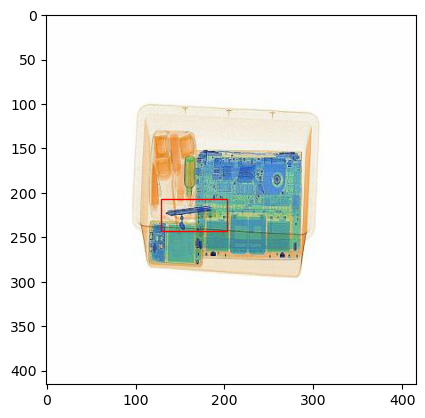

In [7]:
fig, ax = plt.subplots(1)
index = 2048

x_start = df["x_center"][index][0] - df["width"][index][0] / 2
y_start = df["y_center"][index][0] - df["height"][index][0] / 2

rect = patches.Rectangle((x_start * 416, y_start * 416), df["width"][index][0] * 416, df["height"][index][0] * 416, edgecolor="red", facecolor="none")

ax.add_patch(rect)
ax.imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][index]))
print(df["labels"][index][0])

plt.show()

1


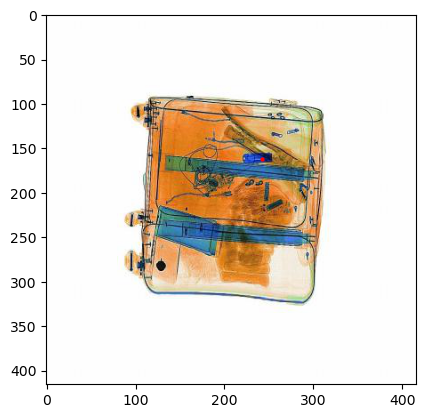

In [8]:
plt.plot(df["x_center"][1993][0] * 416, df["y_center"][1993][0] * 416, marker='o', markersize=2, color="red")
plt.imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][1993]))
print(df["labels"][1993][0])

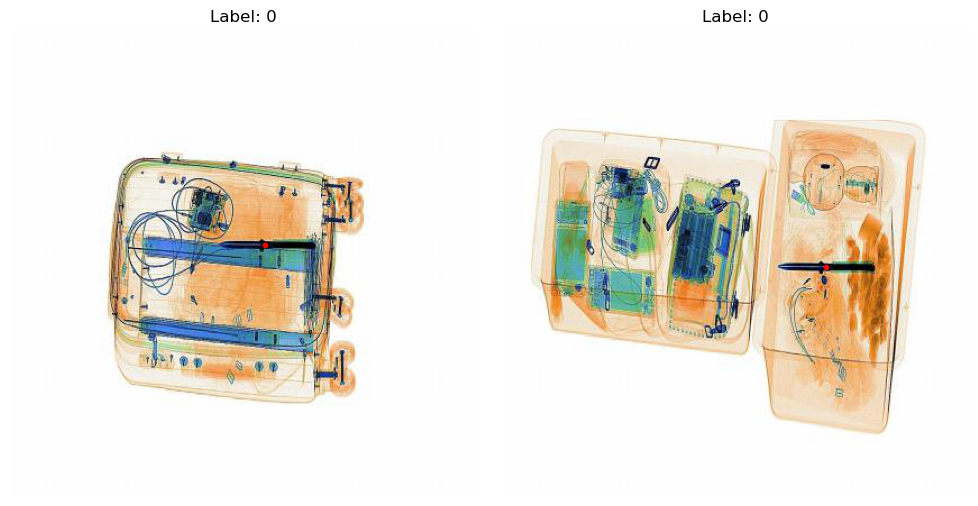

In [9]:
# Class 0

# Create the visualization of 1 rows and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Create a function
for i, idx in enumerate([703, 704]): 
    axes[i].imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx]))
    x = df["x_center"][idx][0] * 416
    y = df["y_center"][idx][0] * 416
    axes[i].plot(x, y, marker='o', markersize=3, color="red")
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Class 0

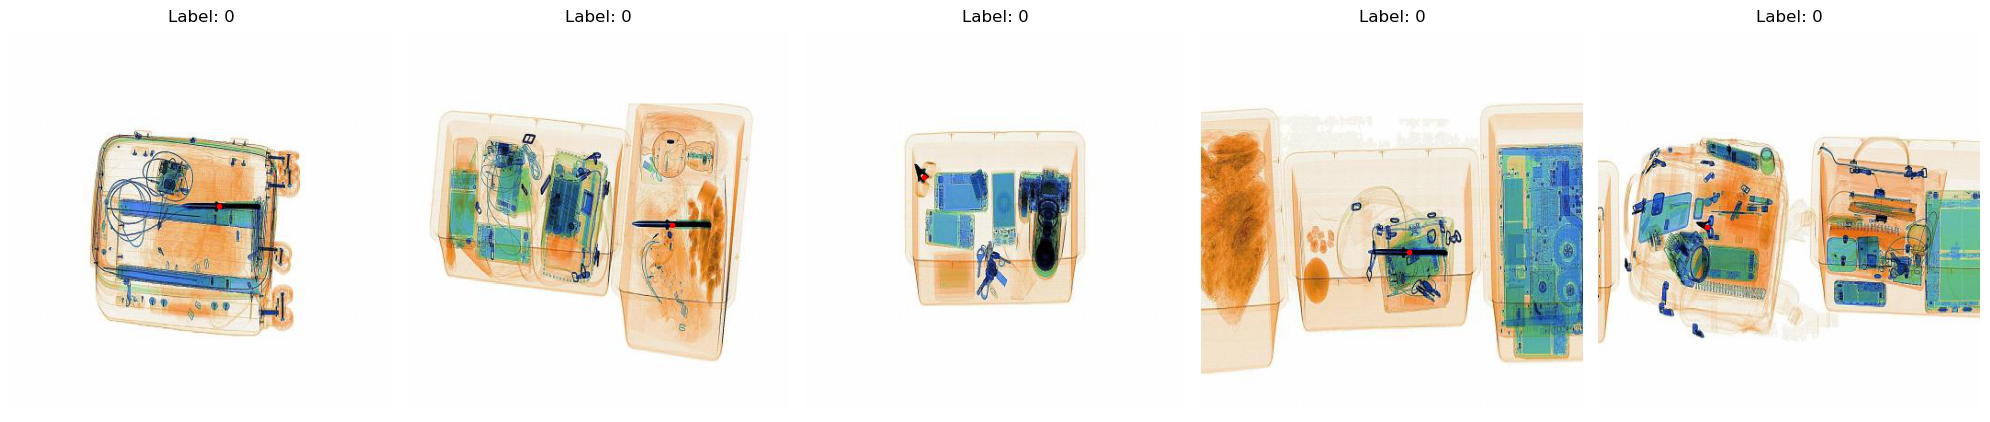

In [14]:
# Misal index gambar yang ingin ditampilkan
indices = [703, 704, 705, 706, 707]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    axes[i].imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx]))
    x = df["x_center"][idx][0] * 416
    y = df["y_center"][idx][0] * 416
    axes[i].plot(x, y, marker='o', markersize=3, color="red")
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Image index: 703, Label: 0


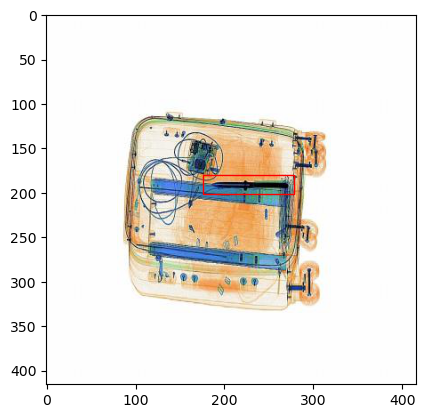

Image index: 704, Label: 0


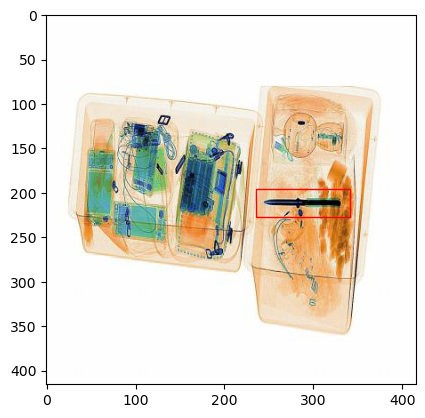

Image index: 705, Label: 0


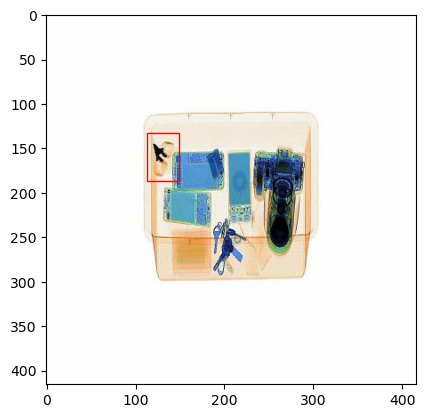

Image index: 706, Label: 0


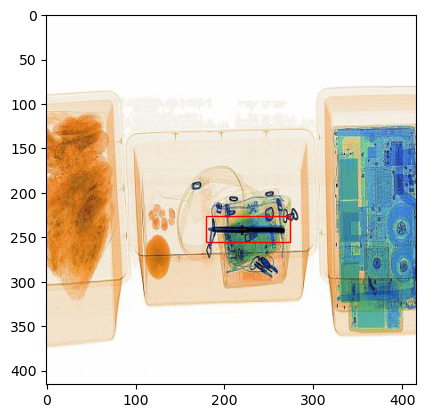

Image index: 707, Label: 0


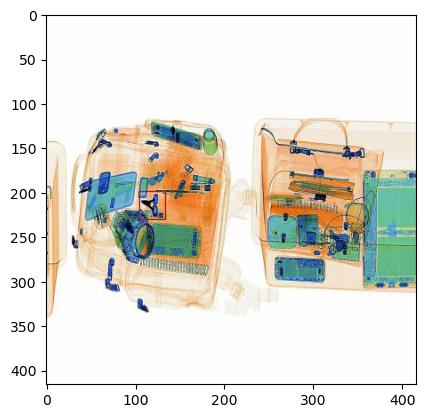

In [28]:
# Asumsikan df, images_path_df, TRAIN_DATASET_PATH sudah terdefinisi

start_index = [703, 704, 705, 706, 707]  # Mulai dari indeks ini
num_images = 5      # Jumlah gambar yang ingin ditampilkan

for i in start_index:
    fig, ax = plt.subplots(1)
    
    # Ambil koordinat bounding box pertama untuk gambar ke-i
    x_start = df["x_center"][i][0] - df["width"][i][0] / 2
    y_start = df["y_center"][i][0] - df["height"][i][0] / 2
    
    # Buat rectangle bounding box pada gambar (skalakan ke ukuran gambar 416x416)
    rect = patches.Rectangle(
        (x_start * 416, y_start * 416),
        df["width"][i][0] * 416,
        df["height"][i][0] * 416,
        edgecolor="red",
        facecolor="none"
    )
    
    ax.add_patch(rect)
    
    # Load dan tampilkan gambar
    img_path = TRAIN_DATASET_PATH + "images/" + images_path_df["images"][i]
    ax.imshow(Image.open(img_path))
    
    # Tampilkan label bounding box pertama
    print(f"Image index: {i}, Label: {df['labels'][i][0]}")
    
    plt.show()

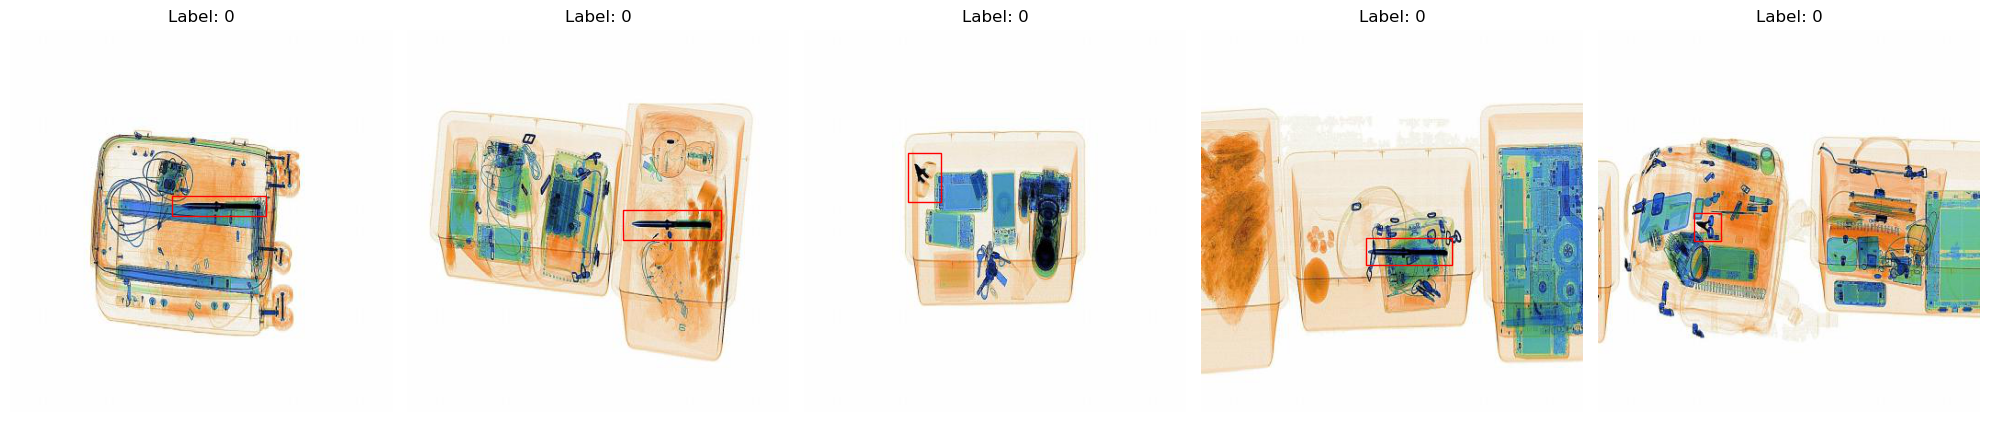

In [29]:
# Misal index gambar yang ingin ditampilkan
indices = [703, 704, 705, 706, 707]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    # Load gambar
    img = Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx])
    axes[i].imshow(img)
    
    # Hitung koordinat bounding box (skalakan ke ukuran 416x416)
    x_start = df["x_center"][idx][0] * 416 - (df["width"][idx][0] * 416) / 2
    y_start = df["y_center"][idx][0] * 416 - (df["height"][idx][0] * 416) / 2
    width = df["width"][idx][0] * 416
    height = df["height"][idx][0] * 416

    # Tambahkan rectangle bounding box
    rect = patches.Rectangle(
        (x_start, y_start),
        width,
        height,
        linewidth=1,
        edgecolor='red',
        facecolor='none'
    )
    axes[i].add_patch(rect)

    # Tambahkan judul label
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Class 1

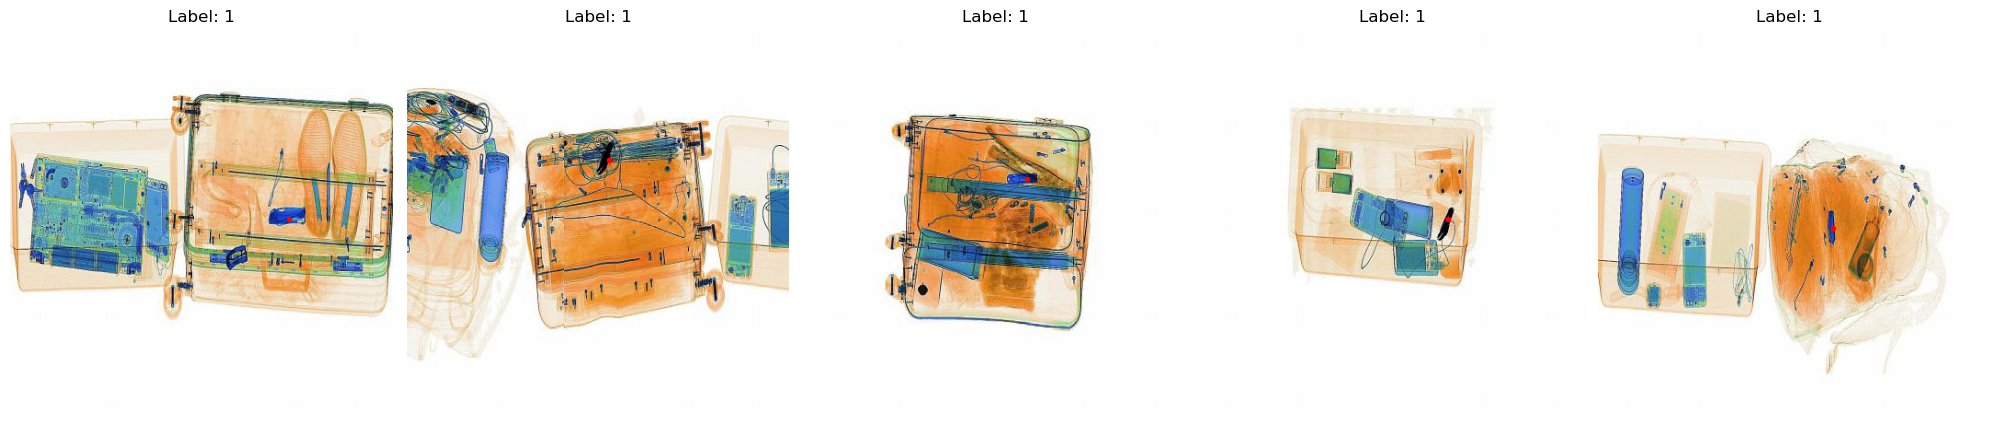

In [20]:
# Misal index gambar yang ingin ditampilkan
indices = [227, 1272, 1993, 1990, 1994]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    axes[i].imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx]))
    x = df["x_center"][idx][0] * 416
    y = df["y_center"][idx][0] * 416
    axes[i].plot(x, y, marker='o', markersize=3, color="red")
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

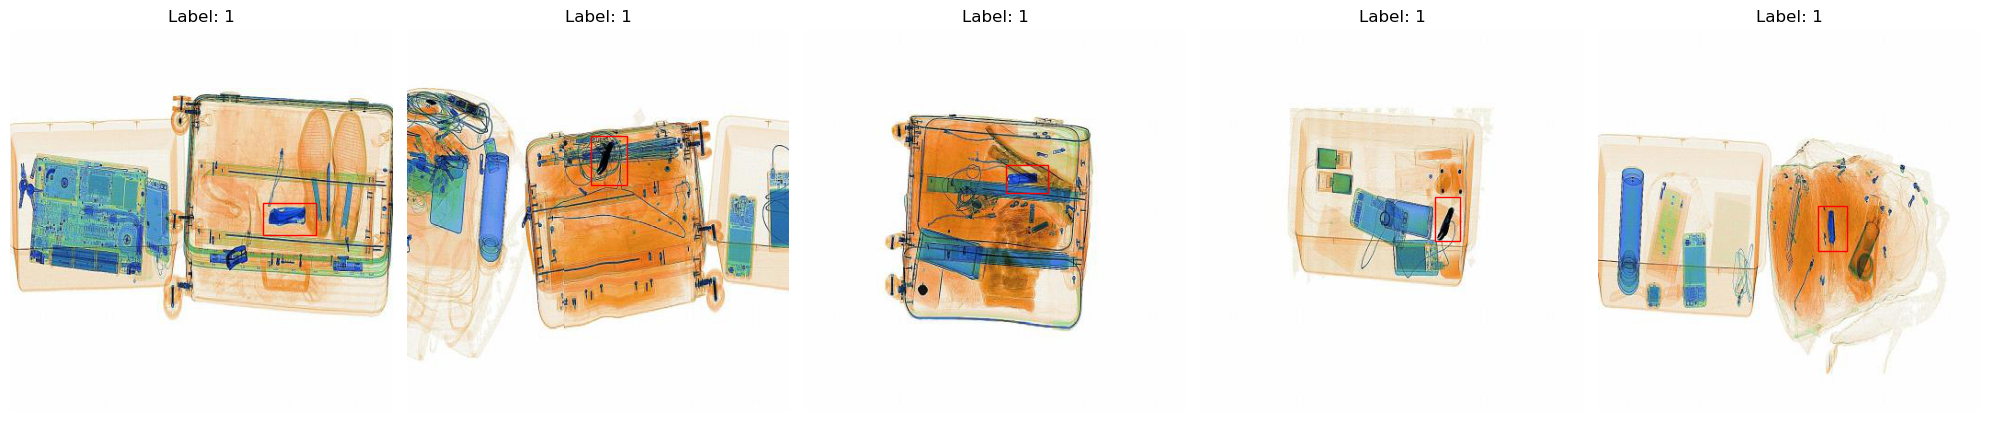

In [30]:
# Misal index gambar yang ingin ditampilkan
indices = [227, 1272, 1993, 1990, 1994]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    # Load gambar
    img = Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx])
    axes[i].imshow(img)
    
    # Hitung koordinat bounding box (skalakan ke ukuran 416x416)
    x_start = df["x_center"][idx][0] * 416 - (df["width"][idx][0] * 416) / 2
    y_start = df["y_center"][idx][0] * 416 - (df["height"][idx][0] * 416) / 2
    width = df["width"][idx][0] * 416
    height = df["height"][idx][0] * 416

    # Tambahkan rectangle bounding box
    rect = patches.Rectangle(
        (x_start, y_start),
        width,
        height,
        linewidth=1,
        edgecolor='red',
        facecolor='none'
    )
    axes[i].add_patch(rect)

    # Tambahkan judul label
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Class 2

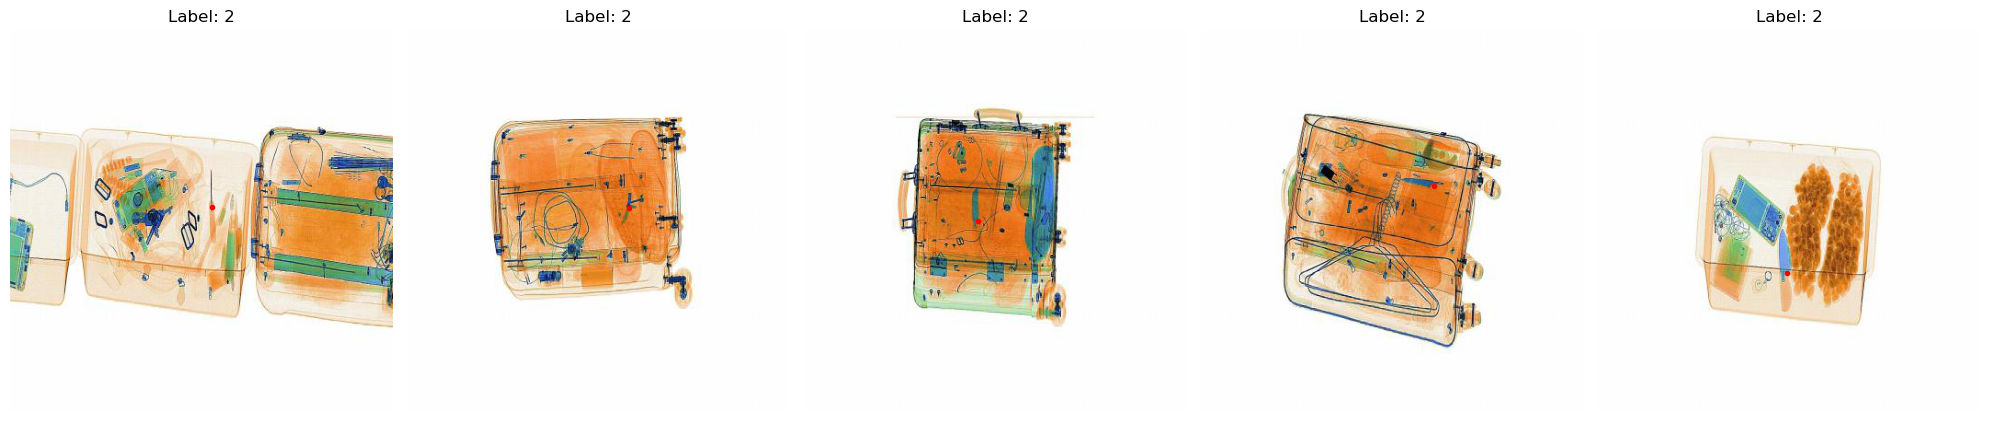

In [22]:
# Misal index gambar yang ingin ditampilkan
indices = [5, 6, 7, 8, 9]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    axes[i].imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx]))
    x = df["x_center"][idx][0] * 416
    y = df["y_center"][idx][0] * 416
    axes[i].plot(x, y, marker='o', markersize=3, color="red")
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

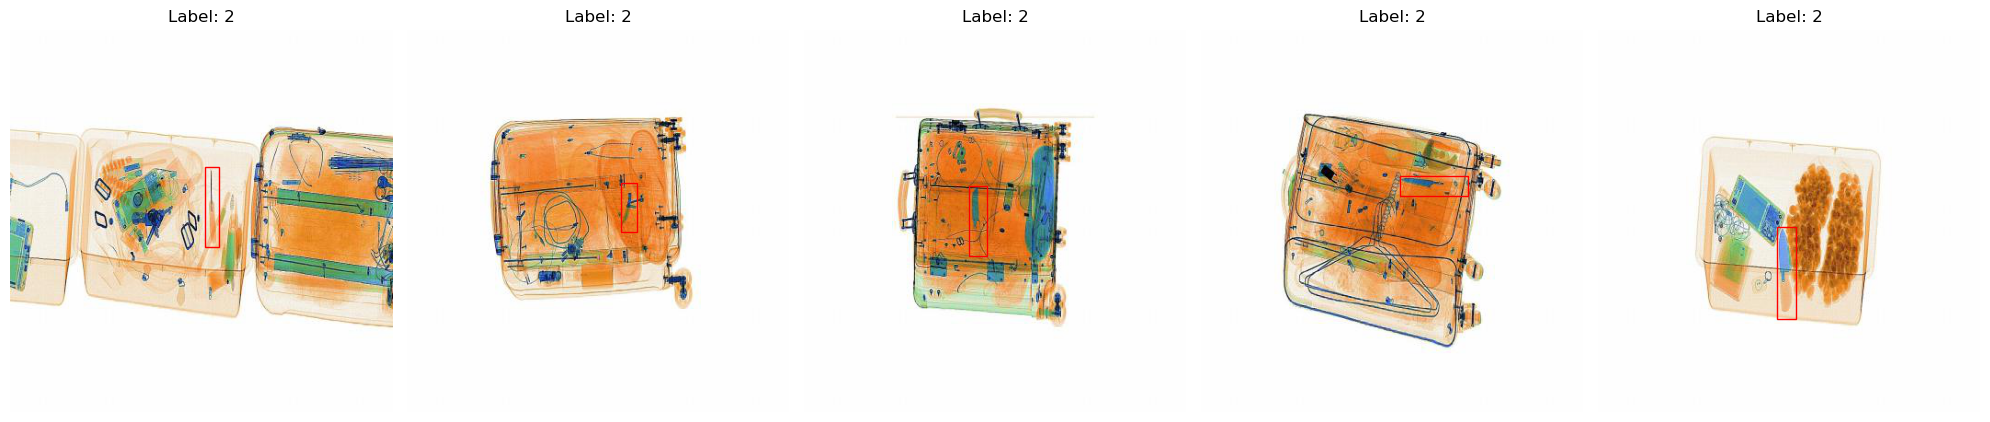

In [31]:
# Misal index gambar yang ingin ditampilkan
indices = [5, 6, 7, 8, 9]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    # Load gambar
    img = Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx])
    axes[i].imshow(img)
    
    # Hitung koordinat bounding box (skalakan ke ukuran 416x416)
    x_start = df["x_center"][idx][0] * 416 - (df["width"][idx][0] * 416) / 2
    y_start = df["y_center"][idx][0] * 416 - (df["height"][idx][0] * 416) / 2
    width = df["width"][idx][0] * 416
    height = df["height"][idx][0] * 416

    # Tambahkan rectangle bounding box
    rect = patches.Rectangle(
        (x_start, y_start),
        width,
        height,
        linewidth=1,
        edgecolor='red',
        facecolor='none'
    )
    axes[i].add_patch(rect)

    # Tambahkan judul label
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Class 3

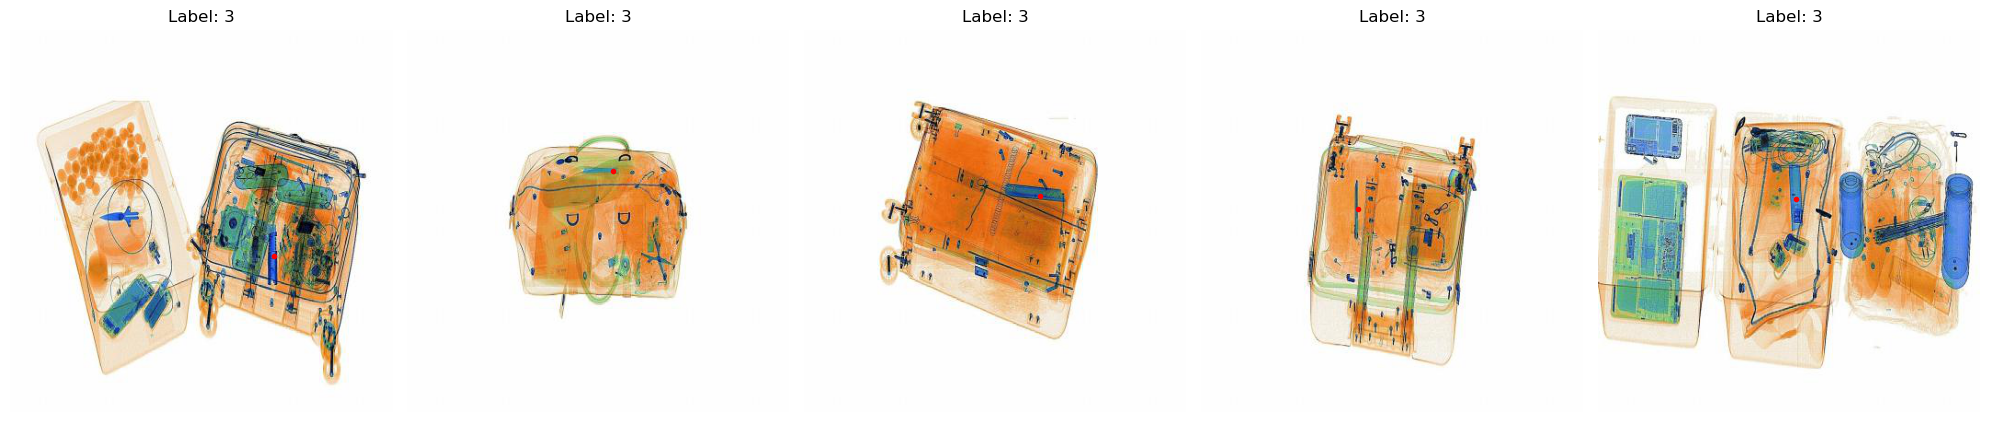

In [23]:
# Misal index gambar yang ingin ditampilkan
indices = [1127, 1233, 1980, 1981, 1988]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    axes[i].imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx]))
    x = df["x_center"][idx][0] * 416
    y = df["y_center"][idx][0] * 416
    axes[i].plot(x, y, marker='o', markersize=3, color="red")
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

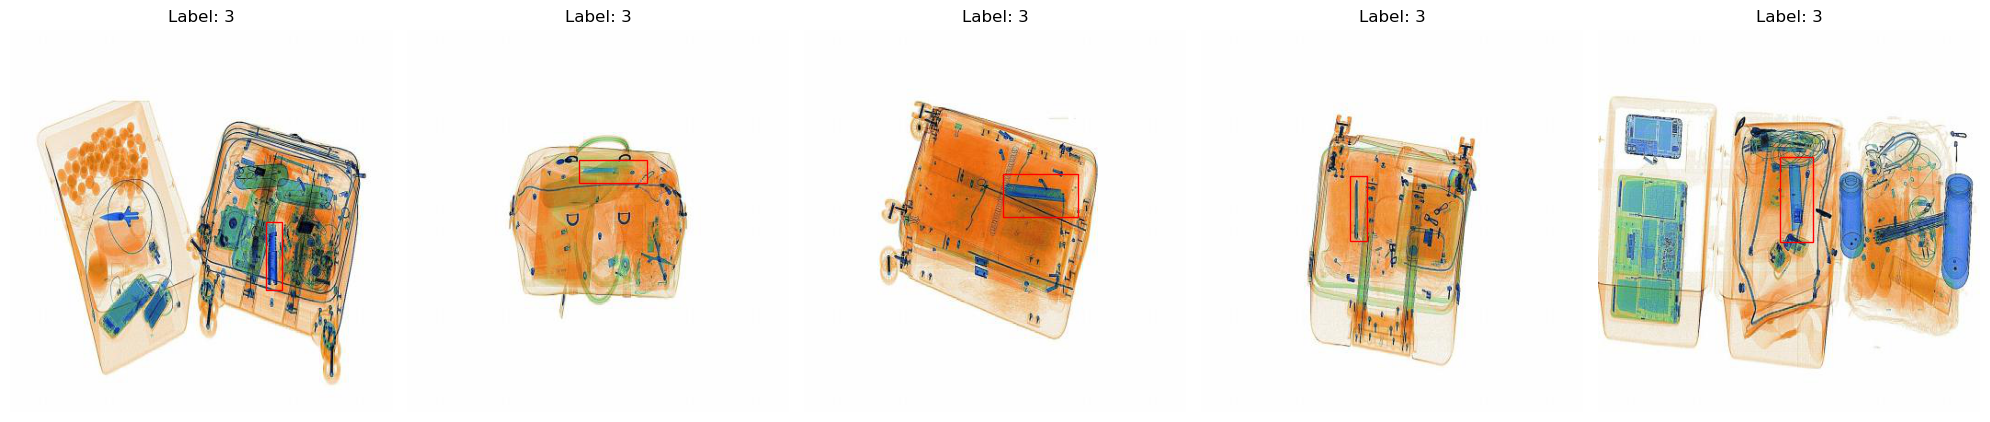

In [33]:
# Misal index gambar yang ingin ditampilkan
indices = [1127, 1233, 1980, 1981, 1988]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    # Load gambar
    img = Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx])
    axes[i].imshow(img)
    
    # Hitung koordinat bounding box (skalakan ke ukuran 416x416)
    x_start = df["x_center"][idx][0] * 416 - (df["width"][idx][0] * 416) / 2
    y_start = df["y_center"][idx][0] * 416 - (df["height"][idx][0] * 416) / 2
    width = df["width"][idx][0] * 416
    height = df["height"][idx][0] * 416

    # Tambahkan rectangle bounding box
    rect = patches.Rectangle(
        (x_start, y_start),
        width,
        height,
        linewidth=1,
        edgecolor='red',
        facecolor='none'
    )
    axes[i].add_patch(rect)

    # Tambahkan judul label
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Class 4

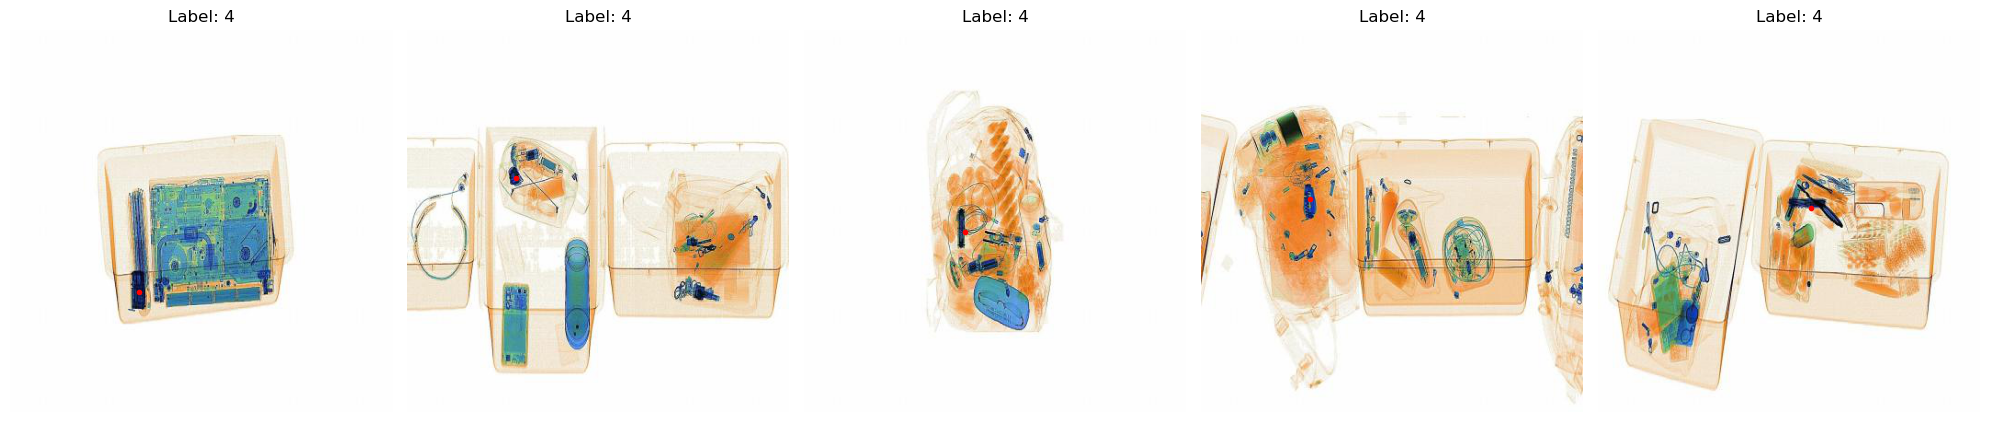

In [25]:
# Misal index gambar yang ingin ditampilkan
indices = [1167, 1987, 1996, 1982, 1978]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    axes[i].imshow(Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx]))
    x = df["x_center"][idx][0] * 416
    y = df["y_center"][idx][0] * 416
    axes[i].plot(x, y, marker='o', markersize=3, color="red")
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

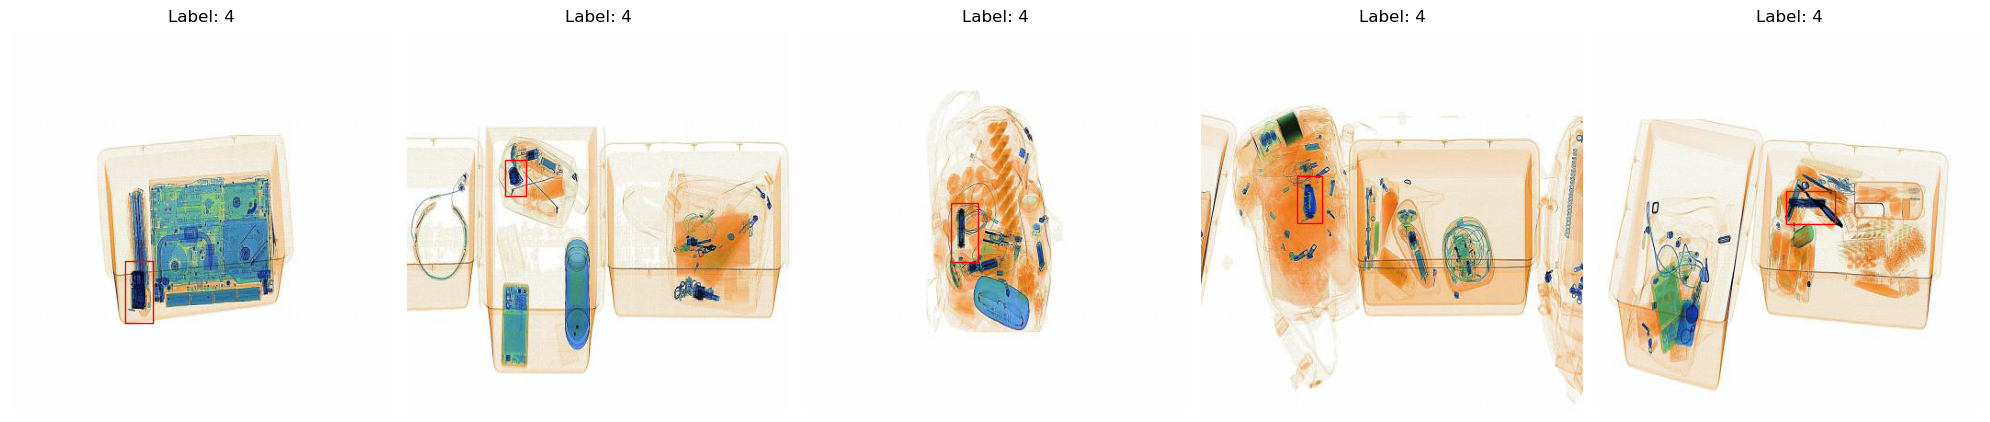

In [34]:
# Misal index gambar yang ingin ditampilkan
indices = [1167, 1987, 1996, 1982, 1978]

# Buat figure dengan 1 baris dan 5 kolom
fig, axes = plt.subplots(1, len(indices), figsize=(20, 5))  # ukuran diperbesar supaya gambar jelas

for i, idx in enumerate(indices):
    # Load gambar
    img = Image.open(TRAIN_DATASET_PATH + "images/" + images_path_df["images"][idx])
    axes[i].imshow(img)
    
    # Hitung koordinat bounding box (skalakan ke ukuran 416x416)
    x_start = df["x_center"][idx][0] * 416 - (df["width"][idx][0] * 416) / 2
    y_start = df["y_center"][idx][0] * 416 - (df["height"][idx][0] * 416) / 2
    width = df["width"][idx][0] * 416
    height = df["height"][idx][0] * 416

    # Tambahkan rectangle bounding box
    rect = patches.Rectangle(
        (x_start, y_start),
        width,
        height,
        linewidth=1,
        edgecolor='red',
        facecolor='none'
    )
    axes[i].add_patch(rect)

    # Tambahkan judul label
    axes[i].set_title(f"Label: {df['labels'][idx][0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# === Fungsi untuk hitung jumlah gambar per kelas ===
def count_images_per_class(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_folder = os.path.join(data_dir, class_name)
        if os.path.isdir(class_folder):
            count = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

# === Hitung jumlah gambar di train dan validasi ===
train_dir = TRAIN_DATASET_PATH
val_dir = VAL_DATASET_PATH

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)

print("Train images per class:")
for k, v in train_counts.items():
    print(f' {k}: {v}')
print("\nValidation images per class:")
for k, v in val_counts.items():
    print(f' {k}: {v}')


Train images per class:
 images: 6181
 labels: 0

Validation images per class:
 images: 1766
 labels: 0


In [11]:
df['label_count'] = df['labels'].apply(len)
print(df[['images', 'label_count']])

                                                 images  label_count
0     009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...            1
1     009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...            1
2     009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...            1
3     009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...            1
4     009012_jpg.rf.bc99877ade8754d2be89119361e7820c...            1
...                                                 ...          ...
6176  042973_jpg.rf.6792837ba2183435721cd7b4e9674ecd...            1
6177  042982_jpg.rf.79a8b11af76f74faa44312da78ee1486...            1
6178  042984_jpg.rf.5005cade401420afa36aac4b818e8dfa...            1
6179  042994_jpg.rf.141176d36edf4a11d33dad95a76e61b6...            1
6180  042996_jpg.rf.09fa6ea27e4110355c4cc9c938e71419...            1

[6181 rows x 2 columns]


In [12]:
# --- Buat mapping label ke nama class ---
class_names = {
    0: "scissor",
    1: "gun",
    2: "knife",
    3: "cutter",
    4: "swiss knife"
}

# --- Tambahkan kolom class names berdasarkan labels ---
def map_labels_to_names(label_list):
    return [class_names.get(lbl, "unknown") for lbl in label_list]

df['class_names'] = df['labels'].apply(map_labels_to_names)

# --- Hitung distribusi instance per kelas ---
all_labels = list(itertools.chain.from_iterable(df['labels']))
label_counts = Counter(all_labels)

# Tampilkan distribusi dengan nama class
for label_id, count in label_counts.items():
    print(f"Class '{class_names[label_id]}' (label {label_id}): {count} instances")

# Kalau ingin bentuk DataFrame untuk distribusi
dist_df = pd.DataFrame({
    'label_id': list(label_counts.keys()),
    'count': list(label_counts.values())
})
dist_df['class_name'] = dist_df['label_id'].map(class_names)
dist_df = dist_df.sort_values(by='count', ascending=False).reset_index(drop=True)

print(dist_df)

Class 'knife' (label 2): 698 instances
Class 'gun' (label 1): 1393 instances
Class 'scissor' (label 0): 1284 instances
Class 'cutter' (label 3): 1379 instances
Class 'swiss knife' (label 4): 1427 instances
   label_id  count   class_name
0         4   1427  swiss knife
1         1   1393          gun
2         3   1379       cutter
3         0   1284      scissor
4         2    698        knife


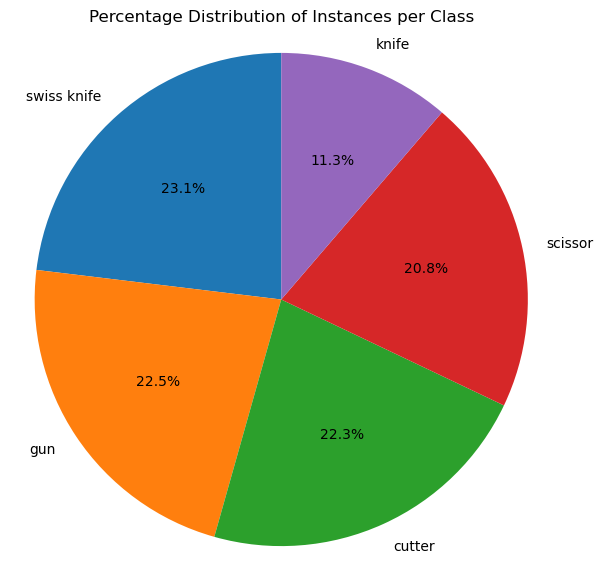

In [13]:
plt.figure(figsize=(7,7))
plt.pie(
    dist_df['count'],
    labels=dist_df['class_name'],
    autopct='%1.1f%%',      # Tampilkan persentase dengan 1 angka di belakang koma
    startangle=90           # Mulai dari sudut 90 derajat agar lebih rapi
)
plt.title('Percentage Distribution of Instances per Class')
plt.axis('equal')  # Membuat pie chart berbentuk lingkaran sempurna
plt.show()

Dari diagram pie ini, dapat dilihat distribusi persentase dari berbagai kategori benda tajam yang terdeteksi. Swiss knife mendominasi dengan 23,1%, diikuti oleh gun (senjata) 22,5%, cutter 22,3%, scissors (gunting) 20,8%, dan knife (pisau biasa) paling sedikit, hanya 11,3%.

Artinya, benda seperti swiss knife, gun, dan cutter paling sering muncul di dataset ini, sementara pisau biasa relatif paling jarang ditemukan. Distribusi ini cukup merata, tidak ada satu kelas yang terlalu dominan secara signifikan, jadi dataset cukup seimbang untuk masing-masing kategori.